<a href="https://colab.research.google.com/github/Devashish-dixit/Nepal-Earthquake-prediction/blob/main/EarthquakeDamageinNepal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries


In [1]:
pip install category_encoders

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder,OrdinalEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree,DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

# Import data

In [8]:
df = pd.read_csv("/content/drive/MyDrive/Data/nepaltraindata.csv")
df.head()

,b_id,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
0,87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
1,87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
2,87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
3,87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
4,87496,32,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


# Exploring the data

Creating a bar chart with the normalized value counts from the "severe_damage" column

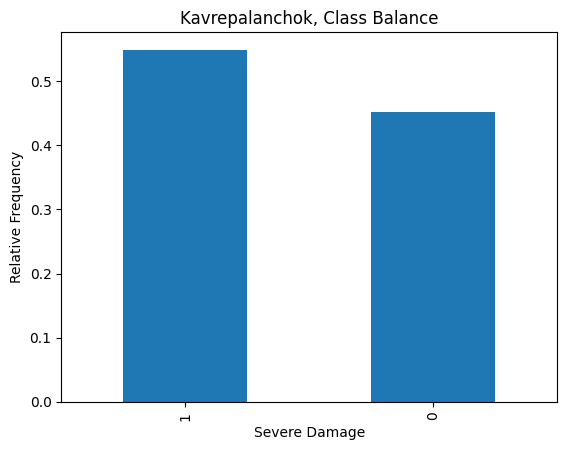

In [9]:
df['severe_damage'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel("Severe Damage")
plt.ylabel("Relative Frequency")
plt.title("Kavrepalanchok, Class Balance");

creating a boxplot that shows the distributions of the "plinth_area_sq_ft" column for both groups in the "severe_damage" column.

Text(0.5, 1.0, 'Kavrepalanchok, Plinth Area vs Building Damage')

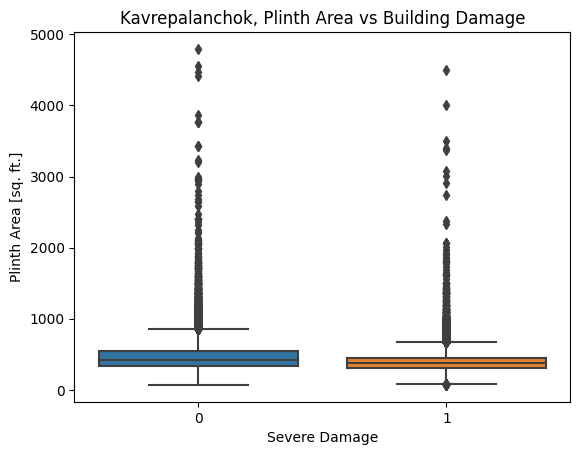

In [10]:
sns.boxplot(x="severe_damage",y="plinth_area_sq_ft",data=df)
plt.xlabel("Severe Damage")
plt.ylabel("Plinth Area [sq. ft.]")
plt.title("Kavrepalanchok, Plinth Area vs Building Damage")

Creating a pivot table of df where the index is "roof_type" and the values come from the "severe_damage" column, aggregated by the mean.

In [11]:
roof_pivot = foundation_pivot = pd.pivot_table(
    df,
    index="roof_type",
    values='severe_damage',
    aggfunc=np.mean
).sort_values(by='severe_damage')
roof_pivot

,severe_damage
roof_type,
RCC/RB/RBC,0.040715
Bamboo/Timber-Heavy roof,0.569477
Bamboo/Timber-Light roof,0.604842


# Splitting the dataset

### Splitting feature matrix and target vector

In [12]:
target="severe_damage"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (76533, 12)
y shape: (76533,)


### Dividing the dataset into training and validation sets using a randomized split.

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=69)

# Building Model

Calculating the baseline accuracy score for the model.

In [14]:
acc_baseline = df['severe_damage'].value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


Creating a  **logistic regression** model to predict building damage.

In [15]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)
model_lr.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

Calculating training and validation accuracy score for model_lr

In [16]:
lr_train_acc = model_lr.score(X_train,y_train)
lr_val_acc = model_lr.score(X_val,y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.6371966158168099
Logistic Regression, Validation Accuracy Score: 0.6368981511726661


##  A **decision tree model** might perform better than the  logistic regression

### Hyperparameter tuning for the decision tree model

In [17]:
depth_hyperparams = range(1, 16)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    model_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=d,random_state=42)
    )
    model_dt.fit(X_train, y_train)
    training_acc.append(model_dt.score(X_train,y_train))
    validation_acc.append(model_dt.score(X_val,y_val))

In [20]:
pd.DataFrame({'Training Accuracy': training_acc, 'Validation Accuracy': validation_acc})

,Training Accuracy,Validation Accuracy
0,0.640888,0.638401
1,0.640888,0.638401
2,0.648385,0.644476
3,0.653905,0.649311
4,0.659720,0.653100
5,0.670401,0.662181
6,0.680577,0.669694
7,0.692304,0.677925
8,0.704962,0.687137
9,0.717555,0.693278


plotting the validation curve for the model

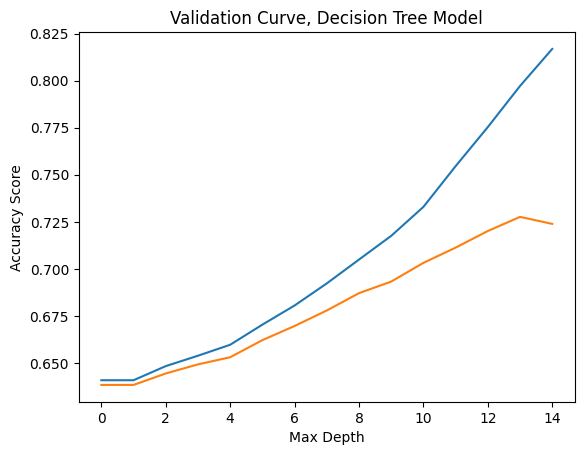

In [21]:
plt.plot(training_acc)
plt.plot(validation_acc)
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Validation Curve, Decision Tree Model");

Upon studying the data, we found that the best value for depth hyperparameters is 10

Creating the final model

In [22]:
final_model_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=10,random_state=42)
    )
final_model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Building with Central Courtyard     9
H-shape                            10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Adobe/mud                1
Brick, mud mortar        2
Stone, mud mortar        3
Brick, cement mortar     4
Other                    5
RC, engineered           6
RC, non-engineered       7
Bamboo                   8
Timber                   9
Stone, cement mortar    10
Stone                   11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

# Evaluation of the model

In [30]:
X_test = pd.read_csv("/content/drive/MyDrive/Data/nepaltestdata.csv" )
y_test_pred = df = pd.DataFrame(final_model_dt.predict(X_test))

In [37]:
df

,0
0,1
1,0
2,0
3,1
4,0
...,...
9797,1
9798,0
9799,0
9800,0


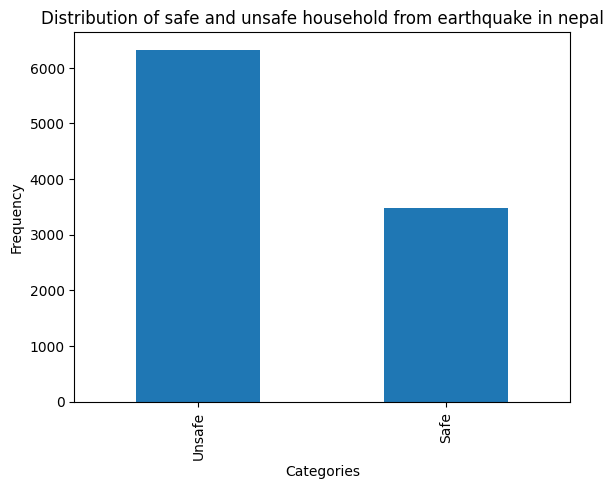

In [42]:
y_test_pred.value_counts().plot(kind='bar')
plt.xticks([0,1], ['Unsafe', 'Safe'])
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Distribution of safe and unsafe household from earthquake in nepal');

# Communicating results

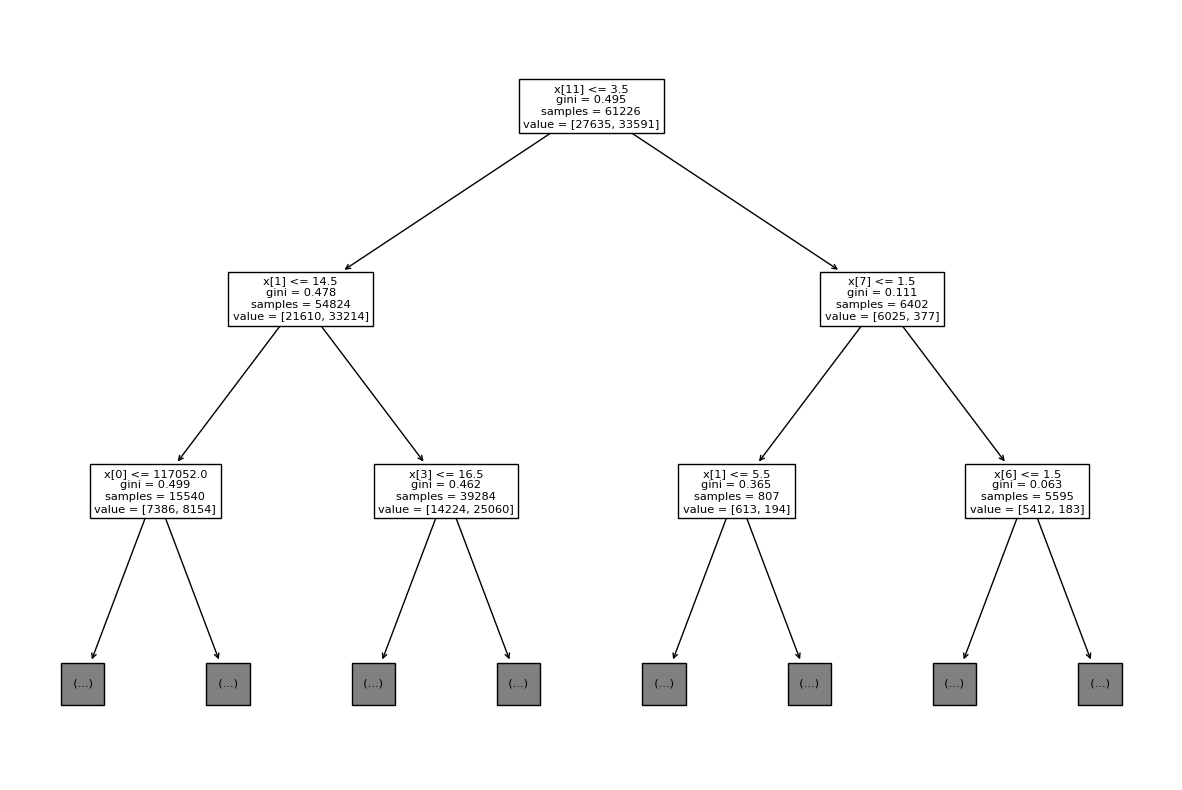

In [43]:
fig,ax = plt.subplots(figsize=(15,10))
plot_tree(final_model_dt.named_steps['decisiontreeclassifier'],max_depth=2);

*In this Jupyter notebook, we embarked on a comprehensive journey to analyze and model building damage prediction. We began by exploring the data, visualizing it with bar charts and boxplots to gain insights into the distributions of key features. Next, we prepared our data by splitting it into feature matrices and target vectors and further divided it into training and validation sets. We established a baseline accuracy score to benchmark our models' performance.*

*Moving on to modeling, we first created a logistic regression model to predict building damage and evaluated its performance on both the training and validation sets. Recognizing the potential of decision tree models, we proceeded to build one, fine-tuning its hyperparameters and plotting the validation curve to determine the optimal depth. After crafting our final model, we subjected it to a test dataset to assess its real-world predictive capabilities.*

*Lastly, we communicated our findings and model results by visually representing the decision tree model. This comprehensive analysis and modeling process provide valuable insights into predicting building damage and offer a foundation for further research and improvements in this domain.*